In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import *

# <center>Pré-processamento dos dados</center>

In [2]:
dataset_path = 'dataset_teste2'

In [3]:
transform_dataset = transforms.Compose(
    [transforms.Resize(size = (224,224)),
     transforms.RandomRotation(degrees=10),
     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
     transforms.ToTensor(),
     transforms.Lambda(lambda x: torch.clamp(x + torch.randn_like(x) * 0.05, 0., 1.)),
     transforms.Normalize(mean=[0.5], std=[0.5])
    ]
)

In [4]:
dataset = datasets.ImageFolder(dataset_path, transform = transform_dataset)

In [5]:
print("Informações sobre o Dataset: \n\n", dataset)
print("\nRótulos: ", dataset.class_to_idx)

Informações sobre o Dataset: 

 Dataset ImageFolder
    Number of datapoints: 1000
    Root location: dataset_teste2
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), scale=(0.9, 1.1), shear=[-10.0, 10.0])
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
               ToTensor()
               Lambda()
               Normalize(mean=[0.5], std=[0.5])
           )

Rótulos:  {'NORMAL': 0, 'PNEUMONIA': 1, 'TUBERCULOSE': 2}


In [6]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [7]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# <center>Implementação da arquitetura CNN</center>

In [8]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    
    nn.Flatten(),
    
    nn.Linear(128 * 28 * 28, 256),
    nn.Dropout(p=0.3),
    nn.ReLU(),

    nn.Linear(256, 128),
    nn.Dropout(p=0.3),
    nn.ReLU(),
    
    nn.Linear(128, 64),
    nn.Dropout(p=0.3),
    nn.ReLU(),
    
    nn.Linear(64, 3)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

Dispositivo utilizado: cuda


In [9]:
model.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=100352, out_features=256, bias=True)
  (14): Dropout(p=0.3, inplace=False)
  (15): ReLU()
  (16): Linear(in_features=256, out_features=128, bias=True

In [10]:
num_epoch = 250
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [11]:
train_losses = []
train_acc = []

training_start_time = time.time()

for epoch in range(num_epoch):
    model.train()
    running_train_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)

    _, predicted = torch.max(outputs.data, 1)

    acc = accuracy_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy())
    train_acc.append(acc)

    print(f"Época {epoch + 1}/{num_epoch} - Perda no treinamento: {train_loss:.6f} - Acurácia: {acc:.4f}")

training_time = time.time() - training_start_time
print(f"\nTempo total de treinamento: {training_time:.2f} segundos")

Época 1/250 - Perda no treinamento: 10.759992 - Acurácia: 0.5833
Época 2/250 - Perda no treinamento: 1.194933 - Acurácia: 0.3333
Época 3/250 - Perda no treinamento: 1.120319 - Acurácia: 0.3333
Época 4/250 - Perda no treinamento: 1.124941 - Acurácia: 0.2500
Época 5/250 - Perda no treinamento: 1.100805 - Acurácia: 0.5000
Época 6/250 - Perda no treinamento: 1.108639 - Acurácia: 0.2500
Época 7/250 - Perda no treinamento: 1.097688 - Acurácia: 0.4167
Época 8/250 - Perda no treinamento: 1.103981 - Acurácia: 0.3333
Época 9/250 - Perda no treinamento: 1.100197 - Acurácia: 0.4167
Época 10/250 - Perda no treinamento: 1.100445 - Acurácia: 0.5833
Época 11/250 - Perda no treinamento: 1.099631 - Acurácia: 0.3333
Época 12/250 - Perda no treinamento: 1.102351 - Acurácia: 0.5833
Época 13/250 - Perda no treinamento: 1.099099 - Acurácia: 0.3333
Época 14/250 - Perda no treinamento: 1.099237 - Acurácia: 0.2500
Época 15/250 - Perda no treinamento: 1.102864 - Acurácia: 0.3333
Época 16/250 - Perda no treinamen

Text(0.5, 0.98, 'Treinamento')

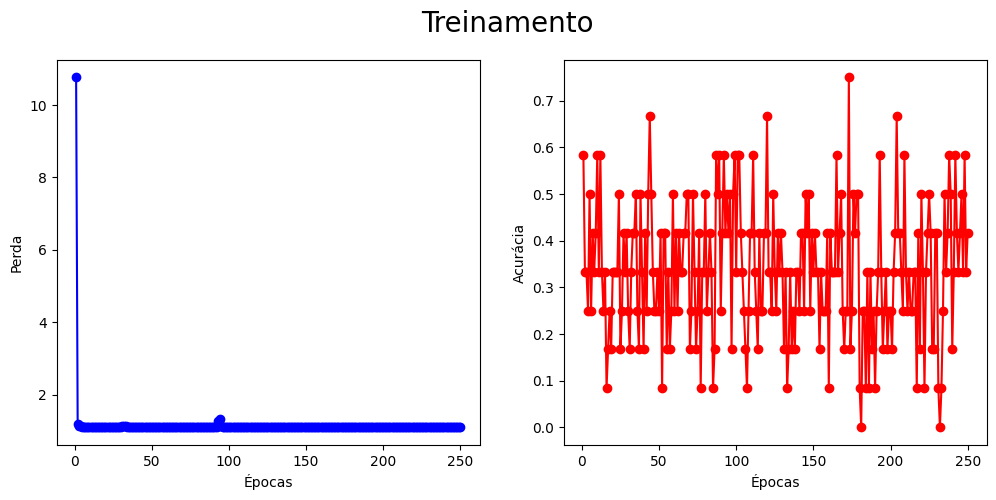

In [12]:
epochs = range(1, num_epoch + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'ro-')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

plt.suptitle("Treinamento", fontsize = 20)

In [13]:
rot_array = []
predt_array = []

model.eval()
    
with torch.no_grad():
        
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        rot_array.extend(labels.cpu().detach().numpy())
        predt_array.extend(predicted.cpu().detach().numpy())

print("!!!Teste finalizado!!!")

!!!Teste finalizado!!!


# <center>Métricas de avaliação</center>

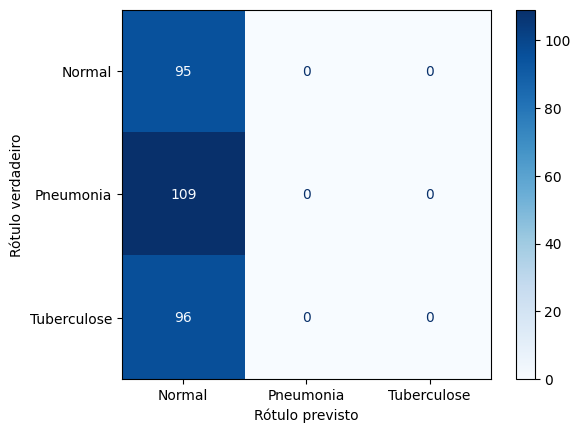

In [14]:
cm = confusion_matrix(rot_array, predt_array)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia', 'Tuberculose'])
disp.plot(cmap=plt.cm.Blues)

plt.xlabel('Rótulo previsto')
plt.ylabel('Rótulo verdadeiro')
plt.show()

In [15]:
acc = accuracy_score(rot_array, predt_array)
print(f"Acurácia: {acc * 100 :.2f}%")

Acurácia: 31.67%


In [16]:
precision = precision_score(rot_array, predt_array, average='weighted')
print(f"Precisão: {precision * 100 :.2f}%")

Precisão: 10.03%


C:\Users\Aleder\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
recall = recall_score(rot_array, predt_array, average='weighted')
print(f"Recall: {recall * 100 :.2f}%")

Recall: 31.67%


In [18]:
f1 = f1_score(rot_array, predt_array, average='weighted')
print(f"F1 Score: {f1 * 100 :.2f}%")

F1 Score: 15.23%
